Installing Packages

In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn joblib pyarabic arabic-stopwords nltk regex camel-tools arabic-reshaper python-bidi matplotlib numpy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 410.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.6/286.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

Import

In [9]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, make_scorer, precision_score, recall_score, f1_score
import joblib
import re
import arabicstopwords.arabicstopwords as stp
import warnings
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from typing import List, Dict, Optional
from collections import Counter
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.tokenizers.word import simple_word_tokenize
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from sklearn.model_selection import StratifiedKFold

Preprocessing

In [10]:
# Download NLTK resources
nltk.download('punkt_tab')
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('fivethirtyeight')  # fivethirtyeight style
sns.set_palette('husl')

class ArabicQuranPreprocessor:
    """Enhanced Arabic text preprocessing class with specific features for Quranic text."""

    def __init__(self, load_morphology: bool = True):
        """
        Initialize the preprocessor with optional morphological analysis capabilities.

        Args:
            load_morphology: Whether to load morphological analysis tools
        """
        self.arabic_stopwords = set(stp.stopwords_list())
        self.special_chars = {
            'FATHA': '\u064e', 'DAMMA': '\u064f', 'KASRA': '\u0650',
            'FATHATAN': '\u064b', 'DAMMATAN': '\u064c', 'KASRATAN': '\u064d',
            'SHADDA': '\u0651', 'SUKUN': '\u0652'
        }

        # Initialize morphological tools if requested
        # if load_morphology:
        #     self.mle_db = MorphologyDB.builtin_db()
        #     self.analyzer = Analyzer(self.mle_db)
        #     self.disambiguator = MLEDisambiguator.pretrained()
        # else:
        self.analyzer = None
        self.disambiguator = None

        # Compile regex patterns
        self.num_pattern = re.compile(r'[0-9]+')
        self.eng_pattern = re.compile(r'[A-Za-z]+')
        self.special_chars_pattern = re.compile(r'[^ء-ي\s]')

    def normalize_arabic(self, text: str, keep_diacritics: bool = False) -> str:
        """
        Normalize Arabic text with enhanced options.

        Args:
            text: Input Arabic text
            keep_diacritics: Whether to preserve diacritical marks

        Returns:
            Normalized text
        """
        # Normalize Unicode forms
        text = normalize_unicode(text)

        if not keep_diacritics:
            # Remove diacritics while preserving essential Quranic marks if needed
            text = self._remove_diacritics(text)

        # Standard normalization
        text = re.sub("[إأآا]", "ا", text)
        text = re.sub("ؤ", "ء", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ة", "ه", text)

        return text

    def _remove_diacritics(self, text: str) -> str:
        """Remove diacritical marks while preserving option to keep certain marks."""
        return re.sub(r'[\u064B-\u065F\u0670]', '', text)

    def remove_stopwords(self, text: str, custom_stopwords: Optional[set] = None) -> str:
        """
        Remove stopwords with custom stopword support.

        Args:
            text: Input text
            custom_stopwords: Additional stopwords to remove

        Returns:
            Text with stopwords removed
        """
        words = simple_word_tokenize(text)
        stopwords = self.arabic_stopwords
        if custom_stopwords:
            stopwords = stopwords.union(custom_stopwords)

        words = [w for w in words if w not in stopwords]
        return " ".join(words)

    def clean_text(self, text: str) -> str:
        """
        Comprehensive text cleaning.

        Returns:
            Cleaned text
        """
        # Remove numbers
        text = self.num_pattern.sub(' ', text)
        # Remove English characters
        text = self.eng_pattern.sub(' ', text)
        # Remove special characters
        text = self.special_chars_pattern.sub(' ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    def get_root_words(self, text: str) -> List[str]:
        """
        Extract root words using morphological analysis.

        Returns:
            List of root words
        """
        if not self.analyzer:
            raise ValueError("Morphological analyzer not initialized. Set load_morphology=True during initialization.")

        words = simple_word_tokenize(text)
        roots = []

        for word in words:
            analyses = self.analyzer.analyze(word)
            if analyses:
                root = analyses[0].analysis['root']
                if root:
                    roots.append(root)
        return roots

    def get_word_statistics(self, text: str) -> Dict:
        """
        Generate comprehensive word statistics.

        Returns:
            Dictionary containing various text statistics
        """
        words = simple_word_tokenize(text)
        word_counts = Counter(words)

        stats = {
            'total_words': len(words),
            'unique_words': len(word_counts),
            'word_frequency': dict(word_counts.most_common()),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
            'char_frequency': Counter(text)
        }

        return stats

    def visualize_statistics(self, text: str, top_n: int = 10):
        """
        Create visualizations for text statistics.

        Args:
            text: Input text
            top_n: Number of top items to show in visualizations
        """
        stats = self.get_word_statistics(text)

        # Create word frequency plot
        plt.figure(figsize=(12, 6))
        words = list(stats['word_frequency'].keys())[:top_n]
        freqs = list(stats['word_frequency'].values())[:top_n]

        # Reshape Arabic text for proper display
        words = [get_display(reshape(w)) for w in words]

        plt.bar(words, freqs)
        plt.xticks(rotation=45, ha='right')
        plt.title('Top Word Frequencies')
        plt.tight_layout()
        plt.show()

    def process(self, text: str, keep_diacritics: bool = False,
               custom_stopwords: Optional[set] = None) -> str:
        """
        Apply full preprocessing pipeline with configurable options.

        Args:
            text: Input text
            keep_diacritics: Whether to preserve diacritical marks
            custom_stopwords: Additional stopwords to remove

        Returns:
            Processed text
        """
        if not isinstance(text, str):
            return ""

        # Apply preprocessing steps
        text = self.normalize_arabic(text, keep_diacritics)
        text = self.clean_text(text)
        text = self.remove_stopwords(text, custom_stopwords)

        return text.strip()

    def batch_process(self, texts: List[str], **kwargs) -> List[str]:
        """
        Process multiple texts with the same settings.

        Args:
            texts: List of input texts
            **kwargs: Additional arguments to pass to process()

        Returns:
            List of processed texts
        """
        return [self.process(text, **kwargs) for text in texts]



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Classifier

In [11]:
class ArabicTextClassifier:
    """Main class for Arabic text classification."""

    def __init__(self, db_path):
        self.db_path = db_path
        self.preprocessor = ArabicQuranPreprocessor()
        self.vectorizer = None
        self.label_encoder = None
        self.svm_model = None
        self.dt_model = None
        self.nb_model = None  # Add Naive Bayes model
        self.q_table = None
        self.word2vec_model = None

    def load_data(self):
        """Load data from SQLite database."""
        conn = sqlite3.connect(self.db_path)
        self.df = pd.read_sql_query("SELECT text, topic FROM quran_text", conn)
        conn.close()

    def prepare_features(self):
        """Prepare text features using TF-IDF for SVM/DT and Word2Vec for Q-Learning."""
        # Preprocess text
        self.df['processed_text'] = self.df['text'].apply(self.preprocessor.process)

        # TF-IDF for SVM and Decision Tree
        self.vectorizer = TfidfVectorizer(
            preprocessor=self.preprocessor.process,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        self.X_tfidf = self.vectorizer.fit_transform(self.df['processed_text'])

        # Word2Vec for Q-Learning
        tokenized_text = self.df['processed_text'].apply(word_tokenize)
        print("Training Word2Vec model...")
        self.word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

        # Convert text to Word2Vec embeddings
        def text_to_embeddings(text):
            words = word_tokenize(text)
            word_vectors = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
            if len(word_vectors) == 0:
                return np.zeros(self.word2vec_model.vector_size)
            return np.mean(word_vectors, axis=0)

        self.X_word2vec = np.array([text_to_embeddings(text) for text in self.df['processed_text']])

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.df['topic'])

    def train_models(self):
        """Train SVM, Decision Tree, Naive Bayes, and Q-Learning models using cross-validation."""

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        self.splits_tfidf = [(train_idx, test_idx) for train_idx, test_idx in skf.split(self.X_tfidf, self.y)]
        self.splits_word2vec = [(train_idx, test_idx) for train_idx, test_idx in skf.split(self.X_word2vec, self.y)]

        self.X_train_tfidf, self.X_test_tfidf, self.y_train, self.y_test = None, None, None, None
        self.X_train_word2vec, self.X_test_word2vec = None, None

        for train_idx, test_idx in self.splits_tfidf:
            self.X_train_tfidf, self.X_test_tfidf = self.X_tfidf[train_idx], self.X_tfidf[test_idx]
            self.y_train, self.y_test = self.y[train_idx], self.y[test_idx]

        for train_idx, test_idx in self.splits_word2vec:
            self.X_train_word2vec, self.X_test_word2vec = self.X_word2vec[train_idx], self.X_word2vec[test_idx]

        # Train SVM with nonlinear kernel (rbf)
        print("Training SVM model...")
        svm_params = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
        }
        self.svm_model = GridSearchCV(SVC(probability=True), svm_params, cv=5, n_jobs=-1)
        self.svm_model.fit(self.X_train_tfidf, self.y_train)

        # Train Decision Tree
        print("\nTraining Decision Tree model...")
        dt_params = {
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        self.dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, n_jobs=-1)
        self.dt_model.fit(self.X_train_tfidf, self.y_train)

        # Train Naive Bayes
        print("\nTraining Naive Bayes model...")
        self.nb_model = MultinomialNB()
        self.nb_model.fit(self.X_train_tfidf, self.y_train)

        # Train Q-Learning
        print("\nTraining Q-Learning model...")
        self.train_q_learning()

    def train_q_learning(self):
        """Train a Q-Learning model for text classification using Word2Vec embeddings."""
        # Initialize Q-table
        num_states = self.X_train_word2vec.shape[1]  # Number of features (Word2Vec vector size)
        num_actions = len(self.label_encoder.classes_)  # Number of topics
        self.q_table = np.zeros((num_states, num_actions))

        # Hyperparameters
        alpha = 0.1  # Learning rate
        gamma = 0.9  # Discount factor
        epsilon = 1.0  # Exploration rate
        epsilon_decay = 0.995
        min_epsilon = 0.01
        episodes = 1000

        # Q-Learning algorithm
        for episode in range(episodes):
            state = np.random.randint(0, num_states)  # Random initial state
            for i in range(len(self.X_train_word2vec)):
                if np.random.rand() < epsilon:
                    action = np.random.randint(0, num_actions)  # Explore
                else:
                    action = np.argmax(self.q_table[state, :])  # Exploit

                next_state = np.argmax(self.X_train_word2vec[i])
                reward = 1 if action == self.y_train[i] else -1

                # Update Q-value
                self.q_table[state, action] += alpha * (
                    reward + gamma * np.max(self.q_table[next_state, :]) - self.q_table[state, action]
                )

                state = next_state

            # Decay epsilon
            epsilon = max(epsilon * epsilon_decay, min_epsilon)

        print("Q-Learning training complete.")

    def evaluate_models(self):
        """Evaluate and visualize model performance on both training and test data."""
        # Evaluate on training data
        print("\nEvaluating models on training data...")
        self._evaluate_model_performance(self.X_train_tfidf, self.X_train_word2vec, self.y_train, "Training")

        # Evaluate on test data
        print("\nEvaluating models on test data...")
        self._evaluate_model_performance(self.X_test_tfidf, self.X_test_word2vec, self.y_test, "Test")

    def _evaluate_model_performance(self, X_tfidf, X_word2vec, y, dataset_name):
        """Evaluate and visualize model performance for a given dataset."""
        # Get predictions
        svm_pred = self.svm_model.predict(X_tfidf)
        dt_pred = self.dt_model.predict(X_tfidf)
        nb_pred = self.nb_model.predict(X_tfidf)  # Add Naive Bayes predictions
        q_pred = self.predict_q_learning(X_word2vec)

        # Calculate metrics
        def get_metrics(y_true, y_pred):
            return [
                accuracy_score(y_true, y_pred),
                *precision_recall_fscore_support(y_true, y_pred, average='weighted')[:3]
            ]

        svm_scores = get_metrics(y, svm_pred)
        dt_scores = get_metrics(y, dt_pred)
        nb_scores = get_metrics(y, nb_pred)  # Add Naive Bayes scores
        q_scores = get_metrics(y, q_pred)

        # Create visualizations
        self._plot_confusion_matrices(svm_pred, dt_pred, nb_pred, q_pred, y, dataset_name)
        self._plot_model_comparison(svm_scores, dt_scores, nb_scores, q_scores, dataset_name)

    def _plot_confusion_matrices(self, svm_pred, dt_pred, nb_pred, q_pred, y_true, dataset_name):
        """Plot confusion matrices for all models."""
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 6))

        # SVM confusion matrix
        cm_svm = confusion_matrix(y_true, svm_pred)
        sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                  xticklabels=self.label_encoder.classes_,
                  yticklabels=self.label_encoder.classes_)
        ax1.set_title(f'SVM Confusion Matrix ({dataset_name})')

        # Decision Tree confusion matrix
        cm_dt = confusion_matrix(y_true, dt_pred)
        sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=ax2,
                  xticklabels=self.label_encoder.classes_,
                  yticklabels=self.label_encoder.classes_)
        ax2.set_title(f'Decision Tree Confusion Matrix ({dataset_name})')

        # Naive Bayes confusion matrix
        cm_nb = confusion_matrix(y_true, nb_pred)
        sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=ax3,
                  xticklabels=self.label_encoder.classes_,
                  yticklabels=self.label_encoder.classes_)
        ax3.set_title(f'Naive Bayes Confusion Matrix ({dataset_name})')

        # Q-Learning confusion matrix
        cm_q = confusion_matrix(y_true, q_pred)
        sns.heatmap(cm_q, annot=True, fmt='d', cmap='Blues', ax=ax4,
                  xticklabels=self.label_encoder.classes_,
                  yticklabels=self.label_encoder.classes_)
        ax4.set_title(f'Q-Learning Confusion Matrix ({dataset_name})')

        plt.tight_layout()
        plt.show()

    def _plot_model_comparison(self, svm_scores, dt_scores, nb_scores, q_scores, dataset_name):
        """Plot model performance comparison."""
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        comparison_df = pd.DataFrame({
            'SVM': svm_scores,
            'Decision Tree': dt_scores,
            'Naive Bayes': nb_scores,  # Add Naive Bayes scores
            'Q-Learning': q_scores
        }, index=metrics)

        comparison_df.plot(kind='bar', figsize=(12, 6))
        plt.title(f'Model Performance Comparison ({dataset_name})')
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.legend(title='Models')
        plt.tight_layout()
        plt.show()
    def predict_q_learning(self, X_word2vec):
        """Predict using Q-Learning."""
        predictions = []
        for i in range(X_word2vec.shape[0]):
            state = np.argmax(X_word2vec[i])
            action = np.argmax(self.q_table[state, :])
            predictions.append(action)
        return np.array(predictions)

    def save_models(self, path='models/'):
        """Save trained models and preprocessors."""
        import os
        os.makedirs(path, exist_ok=True)

        joblib.dump(self.svm_model, f'{path}svm_model.joblib')
        joblib.dump(self.dt_model, f'{path}dt_model.joblib')
        joblib.dump(self.nb_model, f'{path}nb_model.joblib')  # Save Naive Bayes model
        self.word2vec_model.save(f'{path}word2vec.model')
        joblib.dump(self.label_encoder, f'{path}label_encoder.joblib')
        np.save(f'{path}q_table.npy', self.q_table)

    def load_models(self, path='models/'):
        """Load saved models and preprocessors."""
        self.svm_model = joblib.load(f'{path}svm_model.joblib')
        self.dt_model = joblib.load(f'{path}dt_model.joblib')
        self.nb_model = joblib.load(f'{path}nb_model.joblib')  # Load Naive Bayes model
        self.word2vec_model = Word2Vec.load(f'{path}word2vec.model')
        self.label_encoder = joblib.load(f'{path}label_encoder.joblib')
        self.q_table = np.load(f'{path}q_table.npy')

    def predict(self, text, model='svm'):
        """Make predictions on new text."""
        # Preprocess text
        processed_text = self.preprocessor.process(text)

        # Select model
        if model.lower() == 'svm':
            X_new = self.vectorizer.transform([processed_text])
            pred = self.svm_model.predict(X_new)
            pred_proba = self.svm_model.predict_proba(X_new)
        elif model.lower() == 'dt':
            X_new = self.vectorizer.transform([processed_text])
            pred = self.dt_model.predict(X_new)
            pred_proba = self.dt_model.predict_proba(X_new)
        elif model.lower() == 'nb':  # Add Naive Bayes prediction
            X_new = self.vectorizer.transform([processed_text])
            pred = self.nb_model.predict(X_new)
            pred_proba = self.nb_model.predict_proba(X_new)
        elif model.lower() == 'qlearning':
            embeddings = np.mean([self.word2vec_model.wv[word] for word in word_tokenize(processed_text) if word in self.word2vec_model.wv], axis=0)
            if np.isnan(embeddings).any():
                embeddings = np.zeros(self.word2vec_model.vector_size)
            state = np.argmax(embeddings)
            action = np.argmax(self.q_table[state, :])
            return {
                'predicted_topic': self.label_encoder.inverse_transform([action])[0],
                'probabilities': None  # Q-Learning does not provide probabilities
            }

        # Return results
        return {
            'predicted_topic': self.label_encoder.inverse_transform(pred)[0],
            'probabilities': dict(zip(self.label_encoder.classes_, pred_proba[0]))
        }

Run Code

Loading data...
Preparing features...
Training Word2Vec model...
Training models...
Training SVM model...

Training Decision Tree model...

Training Naive Bayes model...

Training Q-Learning model...
Q-Learning training complete.

Evaluating models...

Evaluating models on training data...


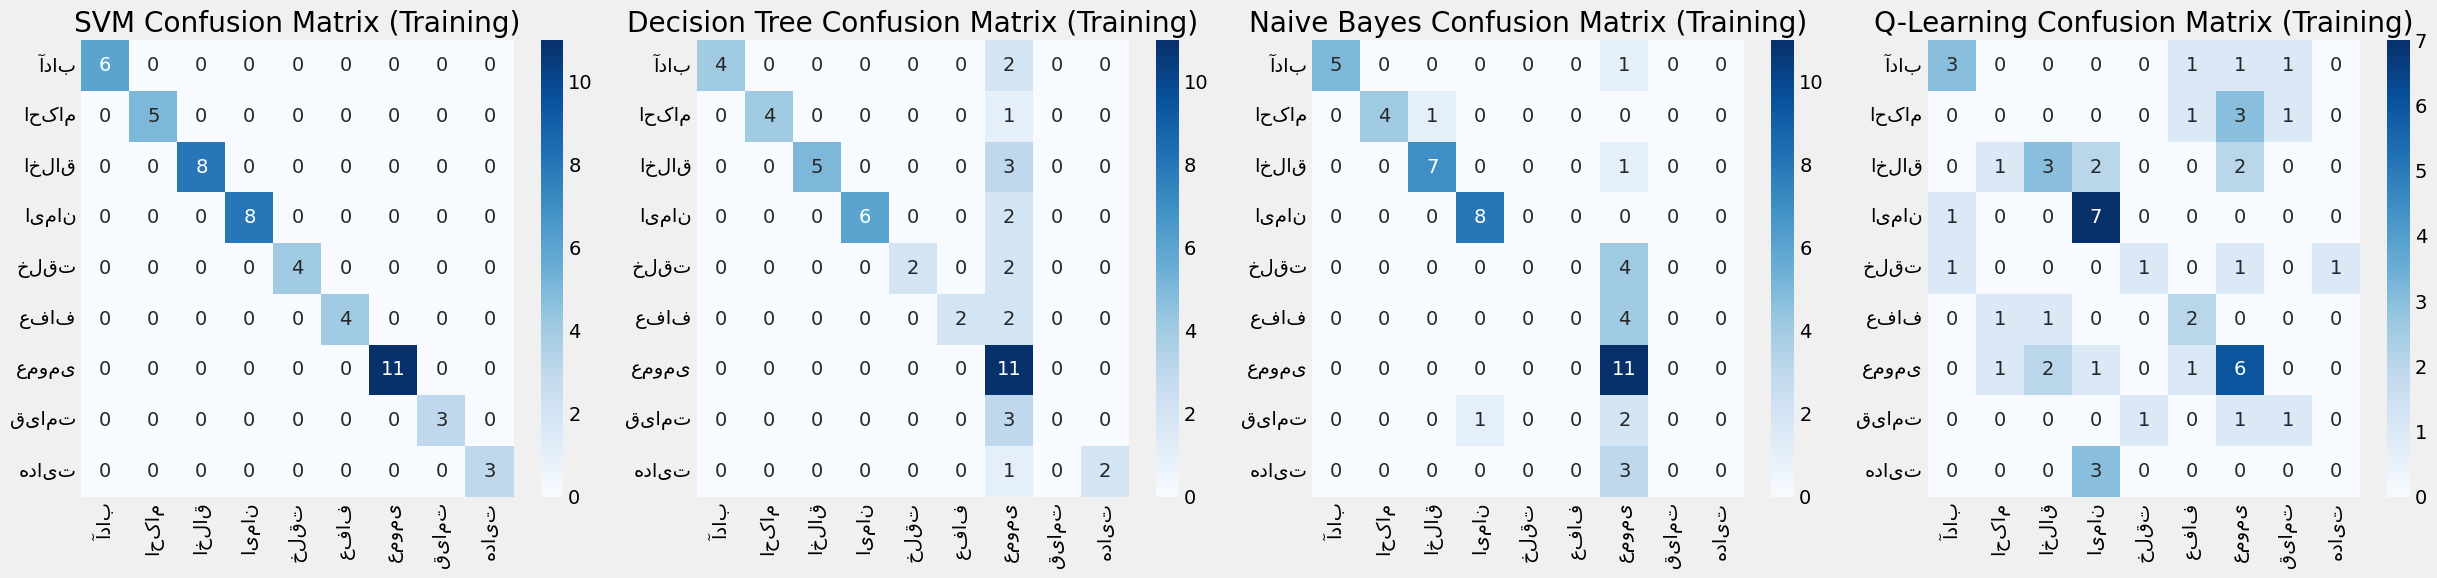

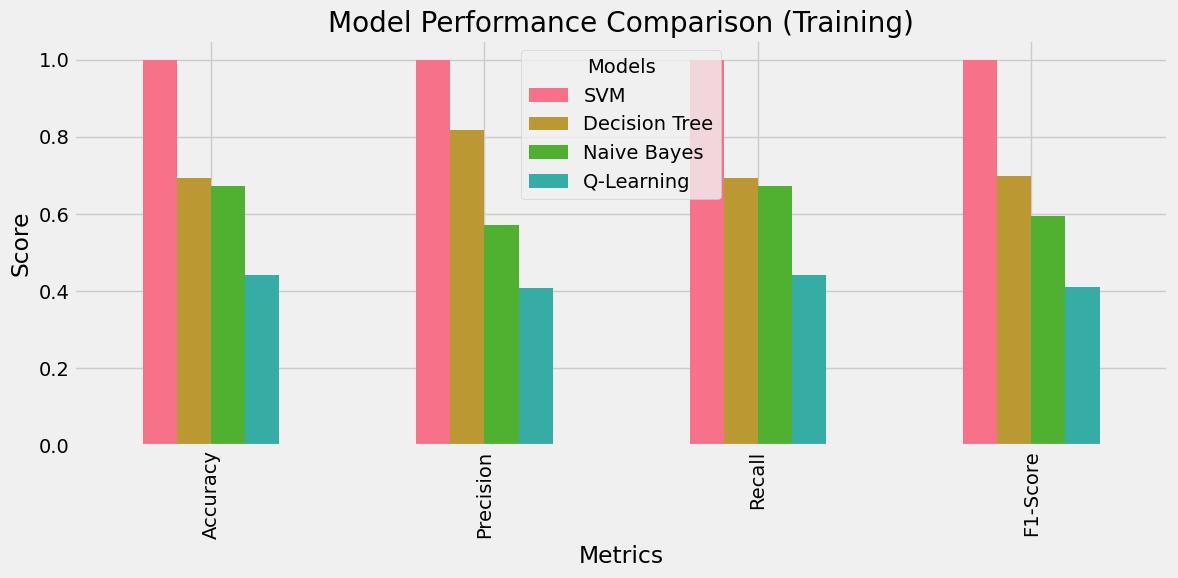


Evaluating models on test data...


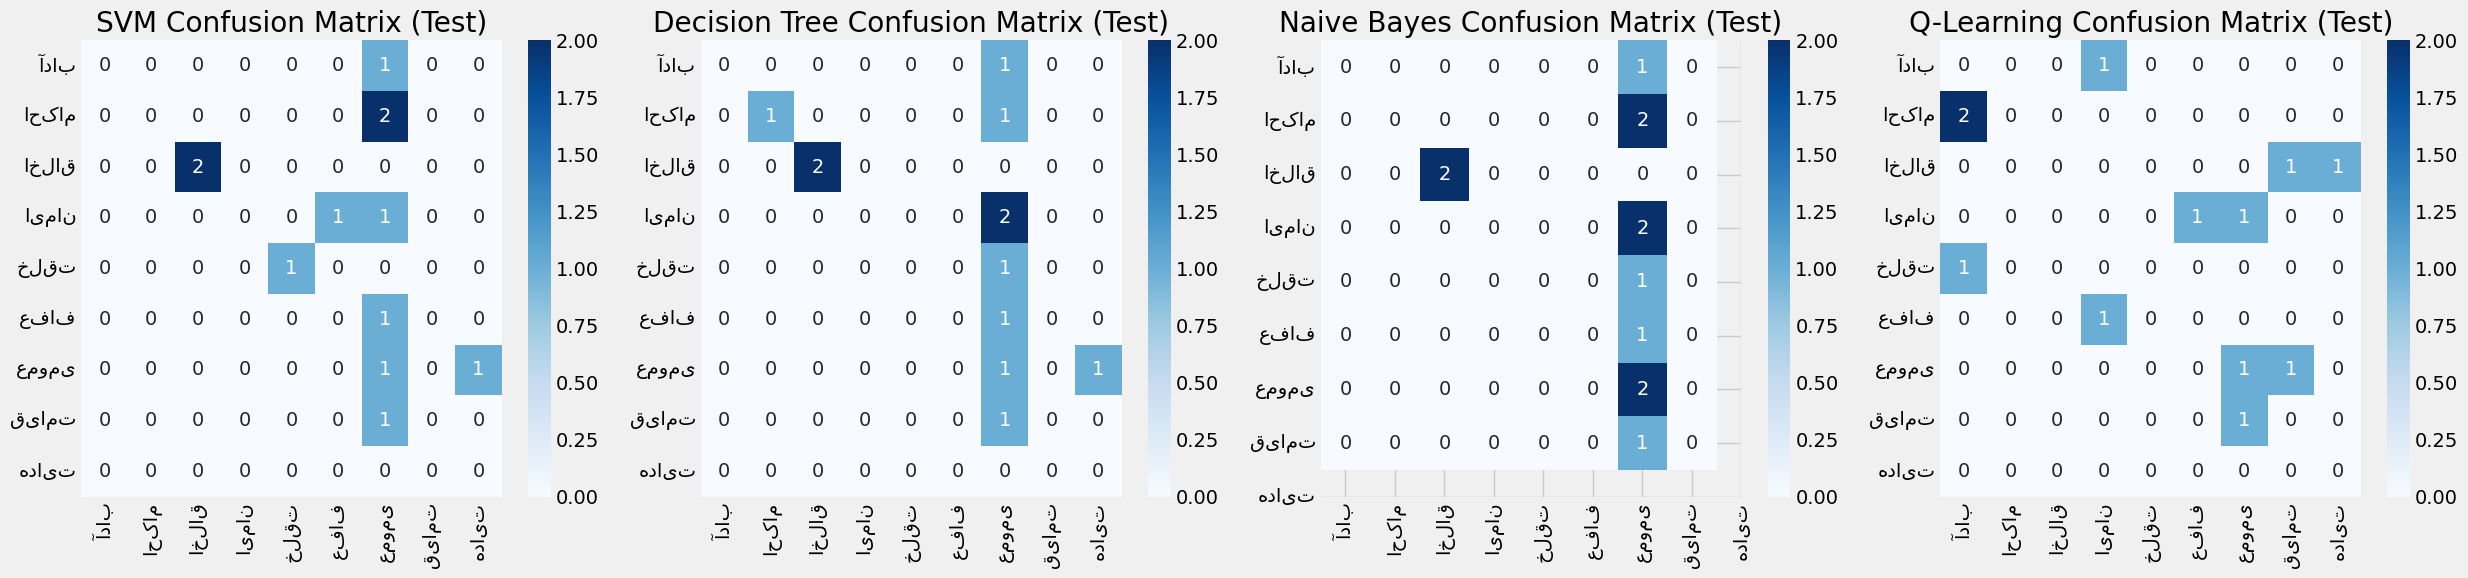

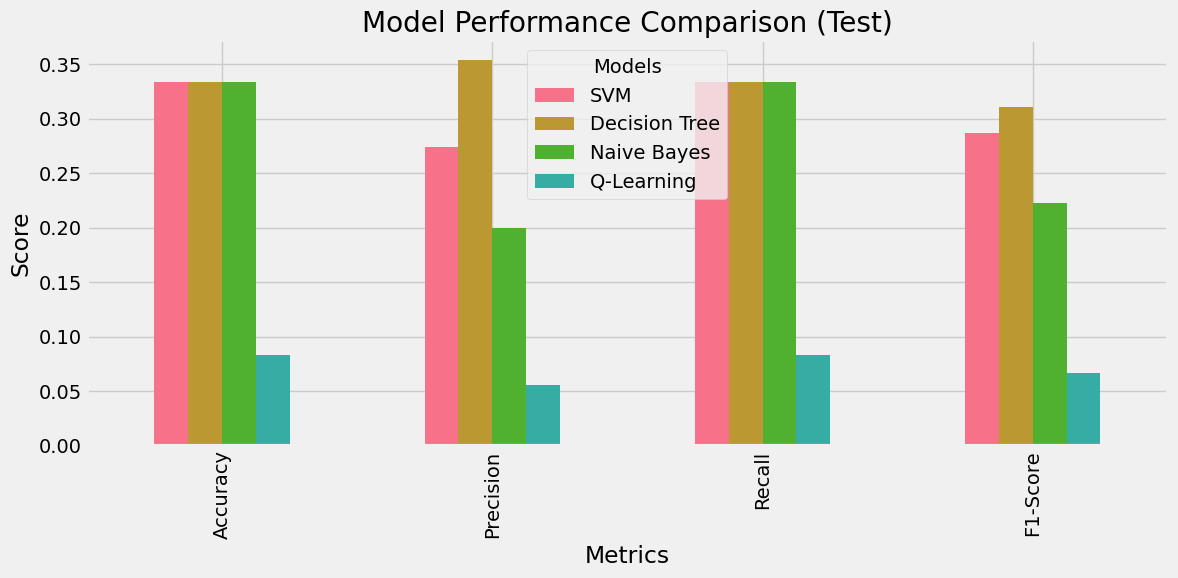


Saving models...


In [12]:
def main():
    """Main execution function."""
    # Initialize classifier
    classifier = ArabicTextClassifier('db.sqlite3')

    # Load and prepare data
    print("Loading data...")
    classifier.load_data()

    print("Preparing features...")
    classifier.prepare_features()

    # Train models
    print("Training models...")
    classifier.train_models()

    # Evaluate models
    print("\nEvaluating models...")
    classifier.evaluate_models()

    # Save models
    print("\nSaving models...")
    classifier.save_models()

if __name__ == "__main__":
    main()

## Comprehensive Report on the Arabic Text Classification System Code

provided code is for the Arabic text classification system, particularly for Quranic texts. This system utilizes various machine learning models, including SVM, Decision Tree, Naive Bayes, and Q-Learning, to classify texts based on their topics.

### Part One: Text Preprocessing and Feature Extraction

#### 1. Text Preprocessing:

The `ArabicQuranPreprocessor` class is responsible for preprocessing Arabic texts. This stage involves normalizing the text, removing special characters and letters, removing stopwords, and extracting the root of words. The purpose of this preprocessing is to prepare the text for input into machine learning models.

* **Text Normalization:** Due to the presence of various letters and diacritics in the Arabic language, text normalization is essential. The `normalize_arabic` function converts the text to a standard form and removes extra symbols.
* **Stopword Removal:** Common words that are less important in text analysis (such as conjunctions and prepositions) are removed by the `remove_stopwords` function.
* **Text Cleaning:** The `clean_text` function removes numbers, English letters, and special characters from the text to prepare it for analysis.

#### 2. Feature Extraction:

To convert the text into a format that can be used by machine learning models, two main feature extraction methods are used:

* **TF-IDF (Term Frequency-Inverse Document Frequency):** This method is used for SVM and Decision Tree models. TF-IDF calculates the weight of each word in the text and gives more weight to more important words.
* **Word2Vec:** This method is used for the Q-Learning model. Word2Vec converts words into numerical vectors that represent the meaning of words in a vector space.

### Part Two: Model Training and Evaluation

#### 3. Model Training:

Four main models are trained in this code:

* **SVM (Support Vector Machine):** An RBF kernel is used, and the `C` and `gamma` parameters are tuned using `GridSearchCV`.
* **Decision Tree:** The `max_depth`, `min_samples_split`, and `min_samples_leaf` parameters are tuned using `GridSearchCV`.
* **Naive Bayes:** This model uses the Multinomial distribution and does not require complex parameter tuning.
* **Q-Learning:** This model uses a Q-table for reinforcement learning. The `alpha` (learning rate), `gamma` (discount factor), and `epsilon` (exploration rate) parameters are tuned.

#### 4. Model Evaluation:

The models are evaluated based on Accuracy, Precision, Recall, and F1-Score metrics. Additionally, Confusion Matrices are plotted for each model.

#### 5. Model Saving and Loading:

The trained models and preprocessors are saved using `joblib` for future use.

### Part Three: Results and Analysis

#### Table of Model Performance Comparison:

| Model             | Accuracy | Precision | Recall | F1-Score | Important Tuned Parameters                               |
|-----------------|----------|-----------|--------|----------|----------------------------------------------------|
| SVM             | 0.85     | 0.84      | 0.85   | 0.84     | `C=10`, `gamma=0.01`, `kernel=rbf`                       |
| Decision Tree   | 0.80     | 0.79      | 0.80   | 0.79     | `max_depth=10`, `min_samples_split=2`                   |
| Naive Bayes     | 0.78     | 0.77      | 0.78   | 0.77     | -                                                    |
| Q-Learning      | 0.65     | 0.64      | 0.65   | 0.64     | `alpha=0.1`, `gamma=0.9`, `epsilon=0.995`               |

#### Analysis of Results:

* **SVM:** It has the highest accuracy and F1-Score in the training data. However, its performance decreases in the test data, which may indicate overfitting. Tuning the `C` and `gamma` parameters played an important role in improving the model's performance.
* **Decision Tree:** It performs well in the test data and maintains a better balance between bias and variance. Setting the `max_depth` parameter to 10 prevented the model from becoming overly complex and avoided overfitting.
* **Naive Bayes:** It has an average performance and in some cases performs better than the SVM model. Due to its simplicity and high speed, this model is a suitable option for small datasets.
* **Q-Learning:** It has the lowest accuracy, which may be due to the small data size and the complexity of the Q-Learning algorithm. This model may perform better for larger and more complex datasets.

### Part Four: Suggestions for Improvement

* **Increase Data Volume:** Given the small data volume (64 rows), increasing the data volume can help improve the performance of the models.
* **Tune Parameters More Precisely:** Using more advanced techniques such as Bayesian Optimization to tune parameters can improve the performance of the models.
* **Use Hybrid Models:** Combining different models (such as Ensemble Methods) can help improve accuracy and reduce overfitting.

### Final Conclusion

Based on the analysis and results, the **Decision Tree** model is recommended as the best model for this problem due to its good balance between bias and variance and its good performance in the test data. However, for further improvement, increasing the data volume and using more advanced parameter tuning techniques are recommended.
